# Project: Markov chains and the supermarket

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use("ggplot")

## 1. Data exploration and preparation

In [29]:
monday = pd.read_csv("data/monday.csv", sep=";", parse_dates=["timestamp"])
tuesday = pd.read_csv("data/tuesday.csv", sep=";", parse_dates=["timestamp"])
wednesday = pd.read_csv("data/wednesday.csv", sep=";", parse_dates=["timestamp"])
thursday = pd.read_csv("data/thursday.csv", sep=";", parse_dates=["timestamp"])
friday = pd.read_csv("data/friday.csv", sep=";", parse_dates=["timestamp"])

In [30]:
frames = monday, tuesday, wednesday, thursday, friday
monday["day"] = "monday"
tuesday["day"] = "tuesday"
wednesday["day"] = "wednesday"
thursday["day"] = "thursday"
friday["day"] = "friday"

In [31]:
tuesday["customer_no"] += monday["customer_no"].max()
wednesday["customer_no"] += tuesday["customer_no"].max()
thursday["customer_no"] += wednesday["customer_no"].max()
friday["customer_no"] += thursday["customer_no"].max()

In [32]:
week = pd.concat(frames).reset_index()
week.head()

,index,timestamp,customer_no,location,day
0,0,2019-09-02 07:03:00,1,dairy,monday
1,1,2019-09-02 07:03:00,2,dairy,monday
2,2,2019-09-02 07:04:00,3,dairy,monday
3,3,2019-09-02 07:04:00,4,dairy,monday
4,4,2019-09-02 07:04:00,5,spices,monday


In [33]:
week['location'] = pd.Categorical(week["location"])
week['loc_num'] = week['location'].cat.codes

### Calculate the total number of customers in each section

In [34]:
week_count = week.groupby(['timestamp', "loc_num", "day"]).agg({"customer_no":"count"}).reset_index()
week_count.rename(columns={"customer_no":"count"}, inplace=True)
week_count.head()

,timestamp,loc_num,day,count
0,2019-09-02 07:03:00,1,monday,2
1,2019-09-02 07:04:00,1,monday,2
2,2019-09-02 07:04:00,3,monday,1
3,2019-09-02 07:04:00,4,monday,3
4,2019-09-02 07:05:00,0,monday,2


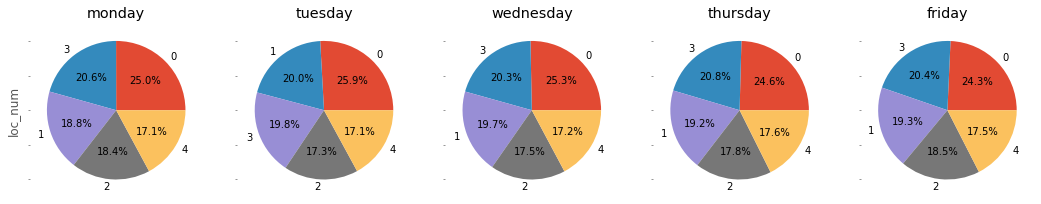

In [35]:
days = week["day"].unique()
f, axes = plt.subplots(1, 5, sharey=True, figsize=(18, 8))
for i, (ax, day) in enumerate(zip(axes, days)):
    week_count.loc[week_count["day"]==day]["loc_num"].value_counts().plot(kind="pie", 
                                                                           autopct='%1.1f%%', 
                                                                           title=day,
                                                                           ax=ax)

### Display cumulated number of customers in each section

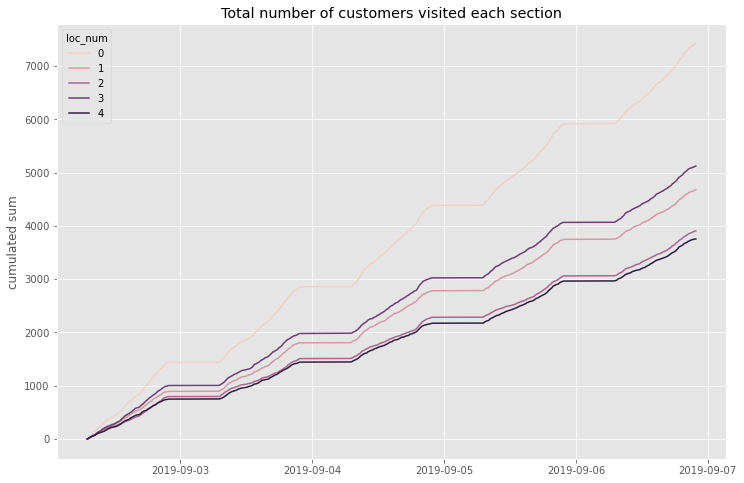

In [36]:
week_count["cumsum"] = week_count.groupby(["loc_num"])["count"].cumsum()

fig, ax = plt.subplots(1, 1)
sns.lineplot(data=week_count, x="timestamp", y="cumsum", hue="loc_num", ax=ax)
ax.set_ylabel("cumulated sum")
ax.set_xlabel("")
ax.set_title("Total number of customers visited each section");

### Display the number of customers at checkout over time

In [37]:
checked_out = week_count[week_count["loc_num"]==0]

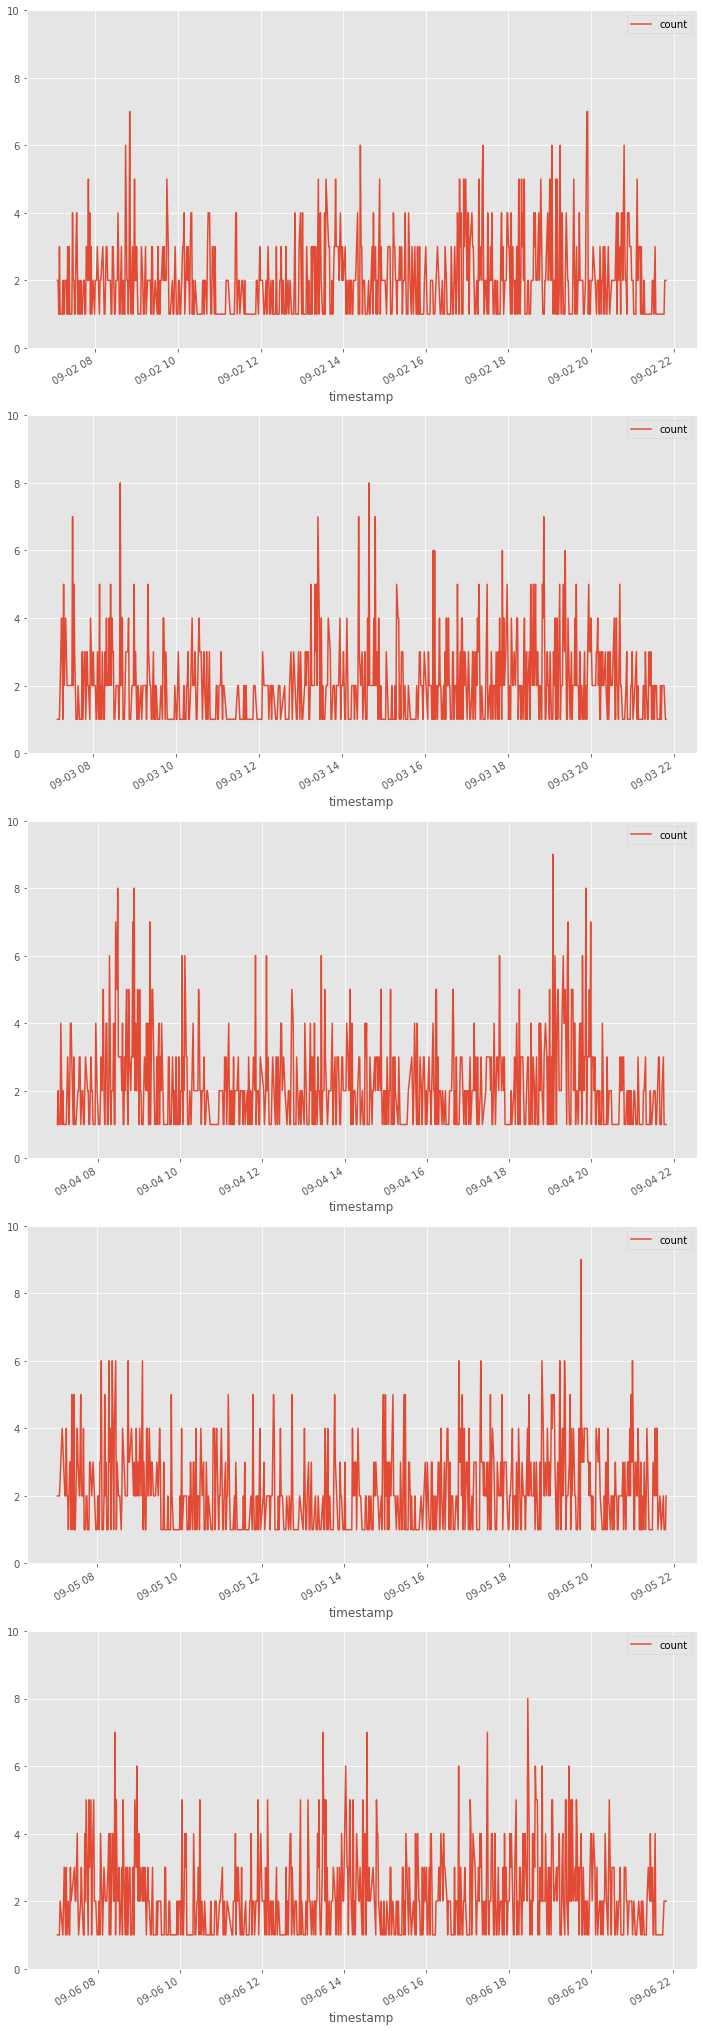

In [38]:
fig, axes = plt.subplots(5, 1, figsize=(12, 40))
for ax, day in zip(axes, days):
    checked_out.loc[checked_out["day"]==day].plot(x="timestamp", y="count", ax=ax)
    ax.set_ylim([0, 10])

### Calculate the time each customer spent in the market

In [39]:
week["start"] = week.groupby(["customer_no"])["timestamp"].transform(lambda x : min(x))
week["end"] = week.groupby(["customer_no"])["timestamp"].transform(lambda x : max(x))

In [40]:
week["time spend in min"] = (week["end"] - week["start"]).dt.seconds/60

In [41]:
week.head(10)

,index,timestamp,customer_no,location,day,loc_num,start,end,time spend in min
0,0,2019-09-02 07:03:00,1,dairy,monday,1,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0
1,1,2019-09-02 07:03:00,2,dairy,monday,1,2019-09-02 07:03:00,2019-09-02 07:06:00,3.0
2,2,2019-09-02 07:04:00,3,dairy,monday,1,2019-09-02 07:04:00,2019-09-02 07:06:00,2.0
3,3,2019-09-02 07:04:00,4,dairy,monday,1,2019-09-02 07:04:00,2019-09-02 07:08:00,4.0
4,4,2019-09-02 07:04:00,5,spices,monday,4,2019-09-02 07:04:00,2019-09-02 07:05:00,1.0
5,5,2019-09-02 07:04:00,6,spices,monday,4,2019-09-02 07:04:00,2019-09-02 07:29:00,25.0
6,6,2019-09-02 07:04:00,7,spices,monday,4,2019-09-02 07:04:00,2019-09-02 07:13:00,9.0
7,7,2019-09-02 07:04:00,8,fruit,monday,3,2019-09-02 07:04:00,2019-09-02 07:07:00,3.0
8,8,2019-09-02 07:05:00,1,checkout,monday,0,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0
9,9,2019-09-02 07:05:00,5,checkout,monday,0,2019-09-02 07:04:00,2019-09-02 07:05:00,1.0


### How many customers didn't checked out

In [42]:
week

,index,timestamp,customer_no,location,day,loc_num,start,end,time spend in min
0,0,2019-09-02 07:03:00,1,dairy,monday,1,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0
1,1,2019-09-02 07:03:00,2,dairy,monday,1,2019-09-02 07:03:00,2019-09-02 07:06:00,3.0
2,2,2019-09-02 07:04:00,3,dairy,monday,1,2019-09-02 07:04:00,2019-09-02 07:06:00,2.0
3,3,2019-09-02 07:04:00,4,dairy,monday,1,2019-09-02 07:04:00,2019-09-02 07:08:00,4.0
4,4,2019-09-02 07:04:00,5,spices,monday,4,2019-09-02 07:04:00,2019-09-02 07:05:00,1.0
...,...,...,...,...,...,...,...,...,...
24872,5120,2019-09-06 21:50:00,7435,dairy,friday,1,2019-09-06 21:41:00,2019-09-06 21:50:00,9.0
24873,5121,2019-09-06 21:50:00,7442,checkout,friday,0,2019-09-06 21:48:00,2019-09-06 21:50:00,2.0
24874,5122,2019-09-06 21:50:00,7443,checkout,friday,0,2019-09-06 21:48:00,2019-09-06 21:50:00,2.0
24875,5123,2019-09-06 21:50:00,7444,drinks,friday,2,2019-09-06 21:50:00,2019-09-06 21:50:00,0.0


In [49]:
mask = week.groupby(["customer_no"])["loc_num"].transform(lambda x : int("".join(map(str, x))))
mask

0          10
1          10
2          10
3          10
4          40
         ... 
24872    1431
24873      10
24874      10
24875       2
24876       4
Name: loc_num, Length: 24877, dtype: int64

In [56]:
transitions = week.groupby(["customer_no"])["loc_num"].transform(lambda x : " ".join(map(str, x)))

In [57]:
transitions.head(20)

0                 1 0
1                 1 0
2                 1 0
3                 1 0
4                 4 0
5     4 1 4 2 4 1 4 0
6           4 2 4 3 0
7                 3 0
8                 1 0
9                 4 0
10    4 1 4 2 4 1 4 0
11          4 2 4 3 0
12                1 0
13                1 0
14              1 3 0
15                3 0
16                2 0
17              4 2 0
18          1 4 1 3 0
19                3 0
Name: loc_num, dtype: object

### Calculate the total number of customers in the supermarket over time.

In [58]:
week.head(10)

,index,timestamp,customer_no,location,day,loc_num,start,end,time spend in min
0,0,2019-09-02 07:03:00,1,dairy,monday,1,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0
1,1,2019-09-02 07:03:00,2,dairy,monday,1,2019-09-02 07:03:00,2019-09-02 07:06:00,3.0
2,2,2019-09-02 07:04:00,3,dairy,monday,1,2019-09-02 07:04:00,2019-09-02 07:06:00,2.0
3,3,2019-09-02 07:04:00,4,dairy,monday,1,2019-09-02 07:04:00,2019-09-02 07:08:00,4.0
4,4,2019-09-02 07:04:00,5,spices,monday,4,2019-09-02 07:04:00,2019-09-02 07:05:00,1.0
5,5,2019-09-02 07:04:00,6,spices,monday,4,2019-09-02 07:04:00,2019-09-02 07:29:00,25.0
6,6,2019-09-02 07:04:00,7,spices,monday,4,2019-09-02 07:04:00,2019-09-02 07:13:00,9.0
7,7,2019-09-02 07:04:00,8,fruit,monday,3,2019-09-02 07:04:00,2019-09-02 07:07:00,3.0
8,8,2019-09-02 07:05:00,1,checkout,monday,0,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0
9,9,2019-09-02 07:05:00,5,checkout,monday,0,2019-09-02 07:04:00,2019-09-02 07:05:00,1.0


In [325]:
week["timestamp"].head(10)

0   2019-09-02 07:03:00
1   2019-09-02 07:03:00
2   2019-09-02 07:04:00
3   2019-09-02 07:04:00
4   2019-09-02 07:04:00
5   2019-09-02 07:04:00
6   2019-09-02 07:04:00
7   2019-09-02 07:04:00
8   2019-09-02 07:05:00
9   2019-09-02 07:05:00
Name: timestamp, dtype: datetime64[ns]

In [323]:
week.loc[0, "end"] - week.loc[0, "start"] 

Timedelta('0 days 00:02:00')

In [345]:
time = np.asarray(week["timestamp"])

In [354]:
week[week["customer_no"]==1]

,timestamp,customer_no,location,day,start,end,time spend in min
0,2019-09-02 07:03:00,1,dairy,monday,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0
8,2019-09-02 07:05:00,1,checkout,monday,2019-09-02 07:03:00,2019-09-02 07:05:00,2.0


In [417]:
mask = np.logical_and(week["timestamp"] < pd.to_datetime("2019-09-02 07:05:00"), time > pd.to_datetime("2019-09-02 07:03:00"))
start_end = week.groupby(["customer_no"])[["start", "end"]].min()

In [422]:
for i in range(1, week["customer_no"].max() + 1):
    mask = np.logical_and(time < start_end.loc[i, "end"], time > start_end.loc[i, "start"])
    week[mask]["timestamp"].unique()

KeyError: 1430

In [416]:
start_end = week.groupby(["customer_no"])[["start", "end"]].min()

,start,end
customer_no,,
1,2019-09-02 07:03:00,2019-09-02 07:05:00
2,2019-09-02 07:03:00,2019-09-02 07:06:00
3,2019-09-02 07:04:00,2019-09-02 07:06:00
4,2019-09-02 07:04:00,2019-09-02 07:08:00
5,2019-09-02 07:04:00,2019-09-02 07:05:00
...,...,...
7436,2019-09-06 21:46:00,2019-09-06 21:48:00
7437,2019-09-06 21:46:00,2019-09-06 21:47:00
7439,2019-09-06 21:47:00,2019-09-06 21:48:00


In [402]:
week.tail()

,timestamp,customer_no,location,day,start,end,time spend in min
24862,2019-09-06 21:48:00,7439,checkout,friday,2019-09-06 21:47:00,2019-09-06 21:48:00,1.0
24865,2019-09-06 21:48:00,7442,dairy,friday,2019-09-06 21:48:00,2019-09-06 21:50:00,2.0
24866,2019-09-06 21:48:00,7443,dairy,friday,2019-09-06 21:48:00,2019-09-06 21:50:00,2.0
24873,2019-09-06 21:50:00,7442,checkout,friday,2019-09-06 21:48:00,2019-09-06 21:50:00,2.0
24874,2019-09-06 21:50:00,7443,checkout,friday,2019-09-06 21:48:00,2019-09-06 21:50:00,2.0
